In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.backend import clear_session
import tensorflow as tf
tf.random.set_seed(2)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy

# Process dataset
Extract data from the txt file for each user. We only extract the data for the time frame where the user is doing one action, not across different actions. Then we segment the data into 2 seconds window.

In [2]:
# file loader
from os.path import isfile

def load_data(file):
    data = pd.read_csv(file, header=None)
    return data.values

In [3]:
window_size = 75   # 50Hz, 75 samples = 1.5s of movement
window_stride = 25
action_types = ('shield', 'reload', 'grenade', 'final')
data_depth = 6

dataset_users = [0, 1, 2, 3]
# dataset_users = [0, 1, 2, 3, 4]

# Function to load dataset
def load_dataset(data_dir, suffix):
    dataset_x = []
    dataset_y = []
    
    for i in suffix:
        user_data_dir = f"{data_dir}{i}"
        print(f"Loading data from {user_data_dir}")
    
        for action_type in action_types:

            for i in range(1, 100, 1):
                # if file exists
                if not isfile(user_data_dir + f"/{action_type}{i}.csv"):
                    # print number of files loaded
                    print(f"Loaded {i-1} {action_type} files")
                    break
                data = load_data(user_data_dir + f"/{action_type}{i}.csv")
                dataset_x.append(np.int32(data))
                dataset_y.append(action_types.index(action_type))

    print("Dataset initialized with size: " + str(len(dataset_y)))
    for i in range(len(action_types)):
        print("Class " + str(i) + " has " + str(dataset_y.count(i)) + " samples")
    dataset_y = to_categorical(dataset_y)
    return dataset_x, np.array(dataset_y)

def load_idle_dataset(data_dir):
    dataset_x = []
    dataset_y = []
    
    for i in dataset_users:
        user_data_dir = f"{data_dir}{i}"
        print(f"Loading idle data from {user_data_dir}")
    
        for i in range(1, 100, 1):
            # if file exists
            if not isfile(user_data_dir + f"/idle{i}.csv"):
                break
            data = load_data(user_data_dir + f"/idle{i}.csv")
            dataset_x.append(np.int32(data))
            dataset_y.append([0.25, 0.25, 0.25, 0.25])

    print("Idle dataset initialized with size: " + str(len(dataset_y)))
    return dataset_x, np.array(dataset_y)

# To do sliding window on the data
def sliding_window(data_X, data_Y, window_size, window_stride):
    dataset_X_w_sliding = []
    dataset_Y_w_sliding = []
    for i in range(len(data_X)):
        for j in range(0, len(data_X[i]) - window_size+1, window_stride):
            dataset_X_w_sliding.append(data_X[i][j:j + window_size])
            dataset_Y_w_sliding.append(data_Y[i])
    return np.array(dataset_X_w_sliding), np.array(dataset_Y_w_sliding)


# load dataset
dataset_x, dataset_y = load_dataset("Dataset/data", [0, 1, 2])

# # concatenate old dataset
# dataset_x_old, dataset_y_old = load_dataset("Dataset/user", [0, 1, 2, 3, 4])
# dataset_x.extend(dataset_x_old)
# dataset_y = np.concatenate((dataset_y, dataset_y_old), axis=0)

# split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.2, stratify = dataset_y, random_state=66)

# backup test set for evaluation
test_x_eval = copy.deepcopy(test_x)
test_y_eval = copy.deepcopy(test_y)

# # combine the training data with idle data
# dataset_x_idle, dataset_y_idle = load_idle_dataset("Dataset/user")
# train_x.extend(dataset_x_idle)
# train_y = np.concatenate((train_y, dataset_y_idle), axis=0)

# sliding window after train_test_split
train_x, train_y = sliding_window(train_x, train_y, window_size, window_stride)
test_x, test_y = sliding_window(test_x, test_y, window_size, window_stride)

# print dataset size after sliding window
print("Dataset size after sliding window: " + str(len(train_y)))

# calculate class weights
class_weights = {}
for i in range(len(action_types)):
    class_weights[i] = 1 / dataset_y[:, i].sum()

# print dataset disribution
train_y_temp = np.argmax(train_y, axis=1)
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(train_y_temp.tolist().count(i)) + " samples")

# backup test_x for c_sim and cosim
test_x_copy = copy.deepcopy(test_x)

# convert data from int16 to float32
train_x, test_x = np.float32(train_x)/4096, np.float32(test_x)/4096
# print("sample test x data: " + str(test_x[0]))

# summary of test dataset
test = np.argmax(test_y, axis=1)
print("\nTest set distribution")
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(test.tolist().count(i)) + " samples")


Loading data from Dataset/data0
Loaded 44 shield files
Loaded 24 reload files
Loaded 44 grenade files
Loaded 24 final files
Loading data from Dataset/data1
Loaded 24 shield files
Loaded 22 reload files
Loaded 24 grenade files
Loaded 24 final files
Loading data from Dataset/data2
Loaded 24 shield files
Loaded 24 reload files
Loaded 24 grenade files
Loaded 24 final files
Dataset initialized with size: 326
Class 0 has 92 samples
Class 1 has 70 samples
Class 2 has 92 samples
Class 3 has 72 samples
Dataset size after sliding window: 927
Class 0 has 237 samples
Class 1 has 181 samples
Class 2 has 306 samples
Class 3 has 203 samples

Test set distribution
Class 0 has 67 samples
Class 1 has 44 samples
Class 2 has 78 samples
Class 3 has 50 samples


In [4]:
# sample data
# print("Sample data: " + str(train_x[0]))
print(train_x[1:2].shape)


(1, 75, 6)


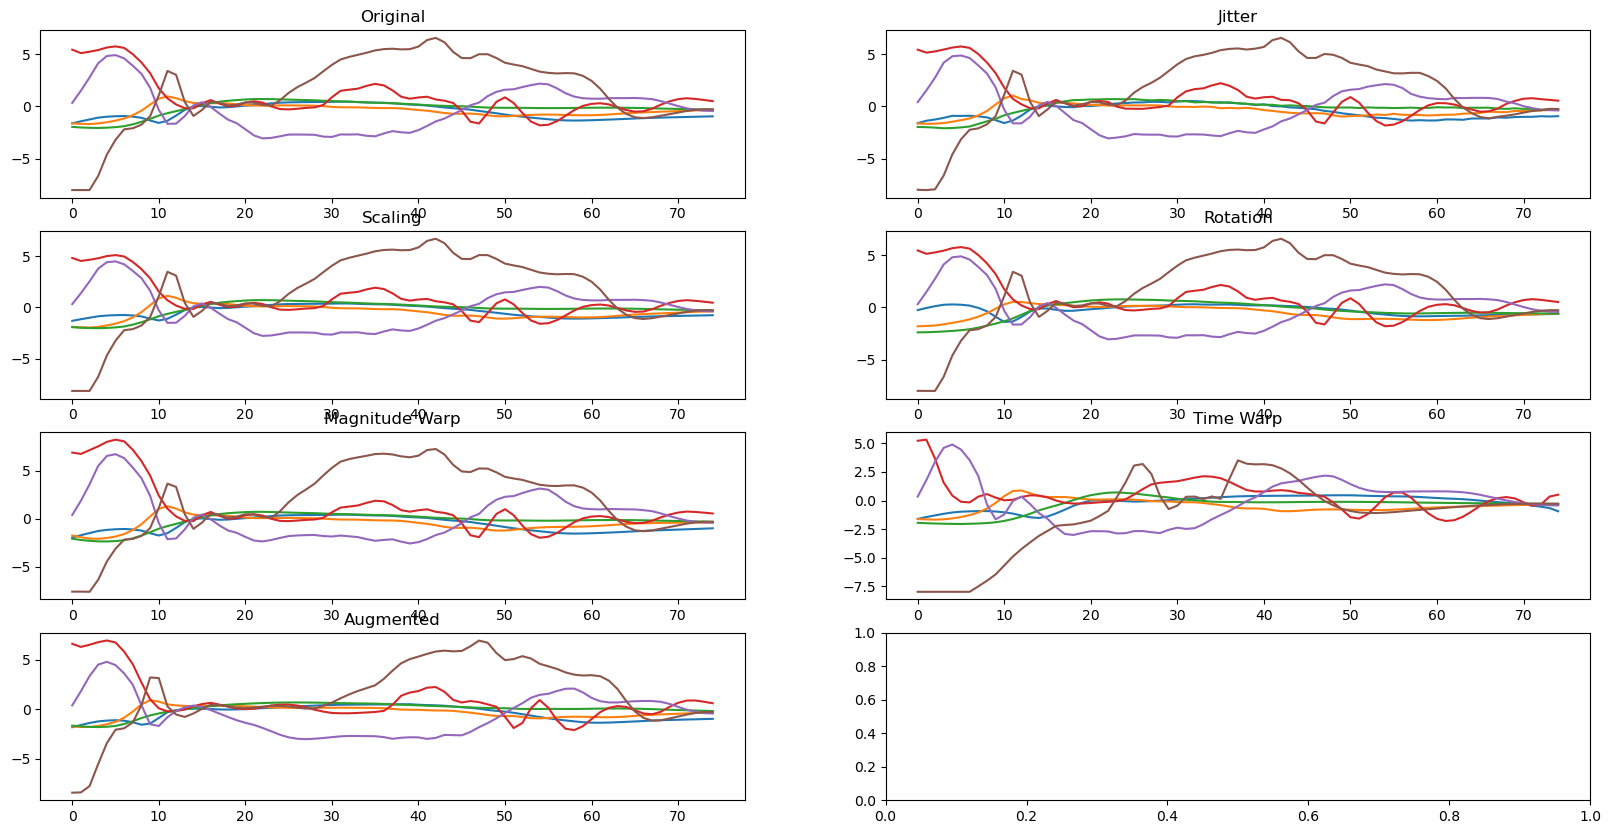

In [5]:
# illustrate the data augmentation
import numpy as np
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation

def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])

def rotation(x, angle_range = np.pi):
    axis = np.random.uniform(low=-1, high=1, size=3)
    angle = np.random.uniform(low=-angle_range/2, high=angle_range/2)
    accel = np.matmul(x[:,:,:3] , axangle2mat(axis,angle))
    axis = np.random.uniform(low=-1, high=1, size=3)
    angle = np.random.uniform(low=-angle_range/2, high=angle_range/2)
    gyro = np.matmul(x[:,:,3:] , axangle2mat(axis,angle))
    return np.concatenate([accel, gyro], axis=-1)

def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])
    
    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[warp]
        else:
            ret[i] = pat
    return ret

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

def time_warp(x, sigma=0.2, knot=2):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

def augment(x):
    # x = jitter(x, sigma=0.01)
    x = np.concatenate([x[:, :, :3], np.array(scaling(x[:, :, 3:], sigma=0.1))], axis=-1)
    x = rotation(x, np.pi/12)
    # x = permutation(x)
    # x = np.concatenate([x[:, :, :3], np.array(magnitude_warp(x[:, :, 3:]))], axis=-1)
    x = window_warp(x, window_ratio=0.2, scales=[0.5, 2.])
    return x
    
def plot_augmented_data(data):
    fig, axs = plt.subplots(4, 2, figsize=(20, 10))
    axs[0, 0].plot(data[0])
    axs[0, 0].set_title("Original")
    axs[0, 1].plot(jitter(data)[0])
    axs[0, 1].set_title("Jitter")
    axs[1, 0].plot(scaling(data)[0])
    axs[1, 0].set_title("Scaling")
    axs[1, 1].plot(rotation(data, np.pi/3)[0])
    axs[1, 1].set_title("Rotation")
    axs[2, 0].plot(magnitude_warp(data)[0])
    axs[2, 0].set_title("Magnitude Warp")
    axs[2, 1].plot(time_warp(data)[0])
    axs[2, 1].set_title("Time Warp")
    axs[3, 0].plot(augment(data)[0])
    axs[3, 0].set_title("Augmented")

    plt.show()
plot_augmented_data(train_x[1:2])

In [6]:
# Data augmentation methods

from scipy.interpolate import CubicSpline      # for warping
from tensorflow import keras
from tensorflow.keras.utils import Sequence
# from augmentation import augment

class DataLoader(Sequence):
    def __init__(self, x_set, y_set, batch_size, aug=True):
        super().__init__()
        self.x, self.y = x_set, y_set
        self.aug_x = x_set
        self.batch_size = batch_size
        self.aug = aug
    
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.aug_x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.aug:
            self.aug_x = augment(self.x)
        


In [7]:
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Softmax, GlobalAveragePooling1D, InputLayer
from tensorflow.keras.optimizers import Adam

clear_session()
model = Sequential()

conv1filters = 32
conv1kernel = 3
conv1stride = 1
model.add(InputLayer(input_shape=(window_size, data_depth)))
model.add(Conv1D(conv1filters, conv1kernel, strides=conv1stride, activation='relu'))
# model.add(Dropout(0.5)) # 50% dropout

# conv2filters = 32
# conv2kernel = 3
# conv2stride = 1
# model.add(Conv1D(conv2filters, conv2kernel, strides=conv2stride, activation='relu'))
# model.add(Dropout(0.5)) # 50% dropout

model.add(GlobalAveragePooling1D())
# model.add(Flatten())

# model.add(Dense(16, activation='relu'))
model.add(Dense(len(action_types)))
model.add(Softmax())

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

# performance before training
# y_prediction = np.argmax(model.predict(test_x), axis=1)
# result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
# sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 73, 32)            608       
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
_________________________________________________________________
softmax (Softmax)            (None, 4)                 0         
Total params: 740
Trainable params: 740
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import datetime

# checkpoint callback
checkpoint_filepath = "model_checkpoint/"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# learning rate reduce on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=200, min_lr=0, verbose=1)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=600, restore_best_weights=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S-w-scaling-rotation-windowwarp")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
import time

# Train the model
def train_network(model, train_x, train_y, test_x, test_y):
    verbose = 1 # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
    epochs = 5000
    batch_size = 32
    # train_augmented = DataLoader(train_x, train_y, batch_size, aug=False)
    train_augmented = DataLoader(train_x, train_y, batch_size, aug=True)
    history = model.fit(train_augmented, \
        epochs=epochs, \
        batch_size=batch_size,\
        validation_data=(test_x, test_y), \
        class_weight = class_weights, \
        callbacks = [model_checkpoint_callback, \
            reduce_lr, \
            early_stopping, \
            tensorboard_callback,\
        ], \
        verbose=verbose)
    # _, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)

    return model, history

start_time = time.time()
model, history = train_network(model, train_x, train_y, test_x, test_y)
print("Training time: %s seconds" % (time.time() - start_time))

Epoch 1/5000
29/29 [==============================] - 4s 26ms/step - loss: 0.0183 - accuracy: 0.3010 - val_loss: 1.3896 - val_accuracy: 0.4142
Epoch 2/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0159 - accuracy: 0.4261 - val_loss: 1.2294 - val_accuracy: 0.4979
Epoch 3/5000
29/29 [==============================] - 0s 7ms/step - loss: 0.0143 - accuracy: 0.5728 - val_loss: 1.1137 - val_accuracy: 0.6653
Epoch 4/5000
29/29 [==============================] - 0s 7ms/step - loss: 0.0131 - accuracy: 0.7314 - val_loss: 1.0314 - val_accuracy: 0.7113
Epoch 5/5000
29/29 [==============================] - 0s 6ms/step - loss: 0.0122 - accuracy: 0.7389 - val_loss: 0.9585 - val_accuracy: 0.7238
Epoch 6/5000
29/29 [==============================] - 0s 5ms/step - loss: 0.0113 - accuracy: 0.7810 - val_loss: 0.8944 - val_accuracy: 0.7322
Epoch 7/5000
29/29 [==============================] - 0s 6ms/step - loss: 0.0105 - accuracy: 0.8047 - val_loss: 0.8413 - val_accuracy: 0.7782
Epoch

# Draw confusion matrix

Proportion of filtered prediction: 0.9497907949790795
Highest false confidence: 0.95612764


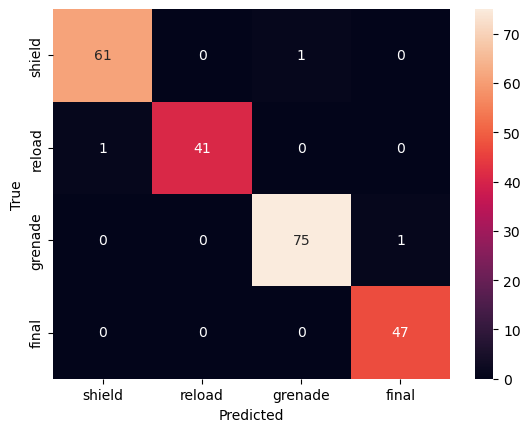

Accuracy: 0.986784140969163


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

highest_false_confidence = 0

model.load_weights(checkpoint_filepath)
y_prediction = model.predict(test_x)

# threshold = 0
threshold = 0.8
# remove all the prediction with probability less than threshold
filtered_pred = []
filtered_test = []
for i in range(len(y_prediction)):
    if np.max(y_prediction[i]) > threshold:
        filtered_pred.append(np.argmax(y_prediction[i]))
        filtered_test.append(np.argmax(test_y[i]))
    if np.max(y_prediction[i]) > highest_false_confidence and np.argmax(y_prediction[i]) != np.argmax(test_y[i]):
        highest_false_confidence = np.max(y_prediction[i])

# print proportion of filtered prediction
print("Proportion of filtered prediction: " + str(len(filtered_pred)/len(y_prediction)))

# print highest false confidence
print("Highest false confidence: " + str(highest_false_confidence))

result = confusion_matrix(filtered_test, filtered_pred)

# result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# print accuracy
print("Accuracy: " + str(np.sum(np.diag(result))/np.sum(result)))


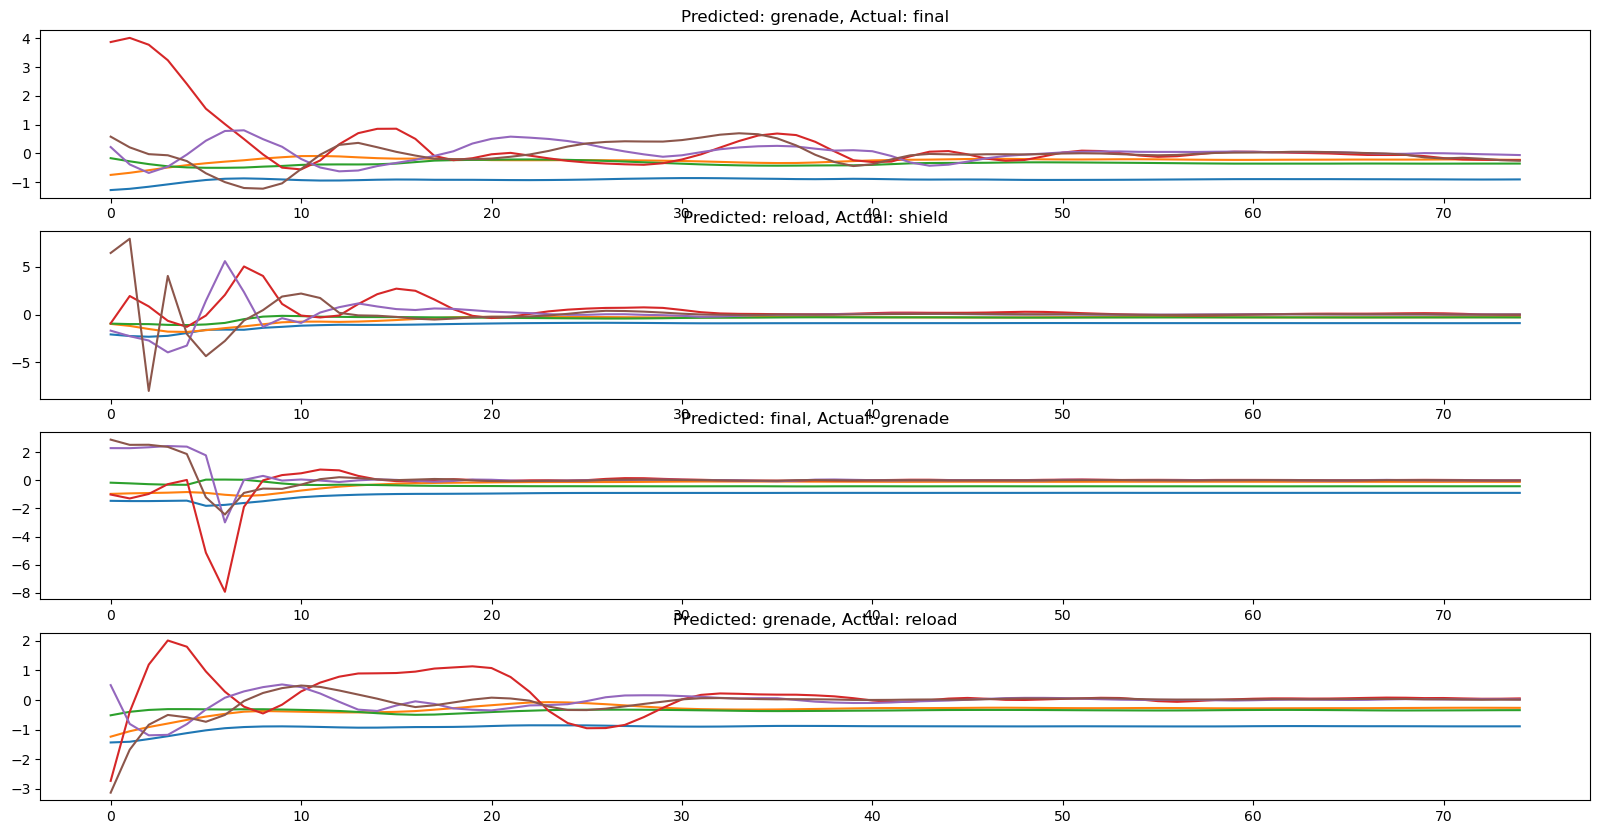

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

highest_false_confidence = 0

model.load_weights(checkpoint_filepath)
y_prediction = model.predict(test_x)
filtered_pred = []
filtered_test = []

fig, axs = plt.subplots(4, figsize=(20, 10))
index = 0
for i in range(len(y_prediction)):
    if np.argmax(y_prediction[i]) != np.argmax(test_y[i]):
        axs[index].plot(test_x[i])
        axs[index].set_title("Predicted: " + action_types[np.argmax(y_prediction[i])] + ", Actual: " + action_types[np.argmax(test_y[i])])
        index += 1
        if index == 4:
            break


best prob:  0.87196416 w wrong predict
best prob:  0.8602304 w correct predict
best prob:  0.8734035 w correct predict
best prob:  0.9007964 w wrong predict
best prob:  0.8402756 w correct predict
best prob:  0.8871528 w wrong predict
best prob:  0.8147743 w wrong predict
best prob:  0.80424505 w wrong predict
best prob:  0.923174 w correct predict
best prob:  0.87091714 w correct predict
best prob:  0.907511 w wrong predict
best prob:  0.8113581 w correct predict
best prob:  0.8161434 w wrong predict
best prob:  0.8068242 w wrong predict
best prob:  0.90007114 w correct predict
best prob:  0.9241984 w wrong predict
best prob:  0.9086259 w correct predict
best prob:  0.828396 w wrong predict
best prob:  0.88578665 w wrong predict
best prob:  0.8126342 w wrong predict
best prob:  0.91338396 w correct predict
best prob:  0.8509084 w wrong predict
best prob:  0.89361537 w correct predict
best prob:  0.85302466 w wrong predict
best prob:  0.87322783 w wrong predict
best prob:  0.8008143 w 

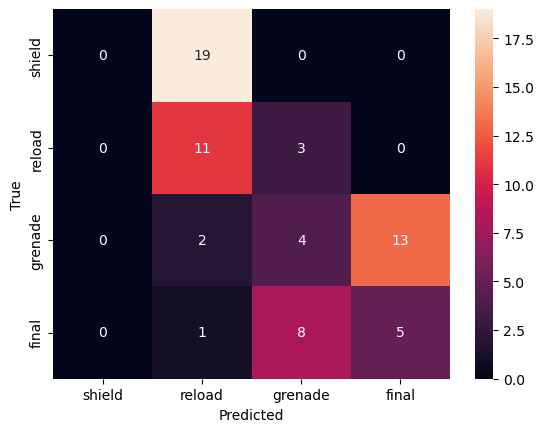

Accuracy: 0.30303030303030304
Highest false confidence: 1.0


In [14]:
# evaluate actual performance
pred = []
actual = []
highest_false_confidence = 0
for i in range(len(test_x_eval)):
    data = np.array(test_x_eval[i])
    # sliding window until the prediction has probability greater than threshold, or end of the sequence and give the prediction with highest probability
    best_pred, best_prob = 0, 0
    batched_data = []
    for w in range(conv1kernel, len(data), conv1stride):
        x = np.array(data[max(0, w-window_size):w])
        x = np.concatenate((np.zeros((window_size - x.shape[0], 6)), x))
        x = np.float32(x/4096.0)
        batched_data.append(x)
    
    batched_data = np.array(batched_data)
    y = model.predict(batched_data)
    # print("correct prediction", np.argmax(test_y_eval[i]))
    # print("prediction for each window:\n", np.concatenate([np.amax(y, axis=-1).reshape((-1, 1)), np.argmax(y, axis=-1).reshape((-1, 1))], axis=-1))

    # find the earliest prediction with probability greater than threshold
    prediction_ended = False
    for j in range(len(y)):
        if np.max(y[j]) > highest_false_confidence and np.argmax(y[j]) != np.argmax(test_y_eval[i]):
            highest_false_confidence = np.max(y[j])
        if np.max(y[j]) > best_prob and not prediction_ended:
            best_pred = np.argmax(y[j])
            best_prob = np.max(y[j])
        if np.max(y[j]) > threshold and not prediction_ended:
            # print("prediction ended early at window " + str(j))
            prediction_ended = True
    if (not prediction_ended):
        print("prediction ended at END OF SEQUENCE")
    print("best prob: ", str(best_prob), "w correct predict" if best_pred == np.argmax(test_y_eval[i]) else "w wrong predict")
    pred.append(best_pred)
    actual.append(np.argmax(test_y_eval[i]))
result = confusion_matrix(actual, pred)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# print accuracy
print("Accuracy: " + str(np.sum(np.diag(result))/np.sum(result)))

# print highest false confidence
print("Highest false confidence: " + str(highest_false_confidence))

In [ ]:
print(f"window shape: {window_size, data_depth}")
print(f"kernel shape: {conv1kernel, data_depth}")
print(f"first layer weights shape: {model.layers[0].get_weights()[0].shape}")
print(f"first layer output shape: {model.layers[0].output_shape}")
print(f"second layer weights shape: {model.layers[3].get_weights()[0].shape}")
print(f"second layer output shape: {model.layers[3].output_shape}")

In [13]:
# print out weights and biases one by one
layers_indexes = [0, 2]

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()
    print(weights[0].shape)
    # print(f"INPUT_DTYPE model_param_{layer_name}_weights")
    # for i in range(weights[0].shape[-1]):
    #     print("index", i)
    #     print(np.transpose(np.transpose(weights[0])[i]))
    # print(f"INPUT_DTYPE model_param_{layer_name}_biases")
    print(weights[1].shape)

(3, 6, 32)
(32,)
(32, 4)
(4,)


In [14]:
# directly print out weights and biases
# layers_indexes = [0, 3]

for layer_index in layers_indexes:
    print(model.layers[layer_index].name)

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()
    if layer_index == 0:
        layer_name = "CNN"
        weights_size_definition = "[CNN_KERNEL_LENGTH][CNN_KERNEL_DEPTH][CNN_KERNEL_COUNT]"
        bias_size_definition = "[CNN_KERNEL_COUNT]"
    else:
        layer_name = "dense"
        weights_size_definition = "[DENSE_INPUT_NODES][DENSE_OUTPUT_NODES]"
        bias_size_definition = "[DENSE_OUTPUT_NODES]"
    # print(f"static CNN_DTYPE {layer_name}_weights{weights_size_definition} = {{" + ", ".join([str(x) for x in weights[0].reshape(-1)]) + "};")
    # print(f"static CNN_DTYPE {layer_name}_bias{bias_size_definition} = {{" + ", ".join([str(x) for x in weights[1]]) + "};")

    # save weights and biases to file
    np.save(f"{layer_name}_weights.npy", weights[0])
    np.save(f"{layer_name}_bias.npy", weights[1])


conv1d
dense


In [ ]:
# directly print out test dataset
n_values_per_line = 10
# dataset_size = len(test_x)
dataset_size = 4
dataset_start_index = 0
print("#define DATASET_SIZE", dataset_size)

# print out float test dataset
print(f"const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for datapoint_index in range(0, len(test_x[text_x_index])):
        for i in range(0, len(test_x[text_x_index][datapoint_index]), n_values_per_line):
            print(", ".join([str(x) for x in test_x[text_x_index][datapoint_index][i:i+n_values_per_line]]) + ",")
print("};") 
    
print(f"const int test_y[DATASET_SIZE][DENSE_OUTPUT_NODES] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for i in range(0, len(test_y[text_x_index]), n_values_per_line):
        print(", ".join([str(int(x)) for x in test_y[text_x_index][i:i+n_values_per_line]]) + ",")
print("};")

# # save the test dataset
np.save("test_x.npy", test_x_copy)
np.save("test_y.npy", test_y)

In [ ]:
# directly print out integer test dataset
n_values_per_line = 10
dataset_size = len(test_x)
# dataset_size = 10
dataset_start_index = 0
print("#define DATASET_SIZE", dataset_size)

# print out float test dataset
print(f"const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for datapoint_index in range(0, len(test_x[text_x_index])):
        for i in range(0, len(test_x[text_x_index][datapoint_index]), n_values_per_line):
            print(", ".join([str(x) for x in test_x_copy[text_x_index][datapoint_index][i:i+n_values_per_line]]) + ",")
print("};") 
    
print(f"const int test_y[DATASET_SIZE][DENSE_OUTPUT_NODES] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for i in range(0, len(test_y[text_x_index]), n_values_per_line):
        print(", ".join([str(int(x)) for x in test_y[text_x_index][i:i+n_values_per_line]]) + ",")
print("};")

# save the test dataset
np.save("test_x.npy", test_x_copy)
np.save("test_y.npy", test_y)

In [ ]:
test_x[0].reshape((1, 75, 6)).shape

In [ ]:
# print model output without the last layer
from keras.models import Model
model_cnn_output = Model(inputs=model.input, outputs=model.layers[0].output)
model_cnn_averaged_output = Model(inputs=model.input, outputs=model.layers[2].output)
model_raw_output = Model(inputs=model.input, outputs=model.layers[3].output)
cnn_result = model_cnn_output.predict(test_x[1].reshape((1, 75, 6)))
cnn_average = model_cnn_averaged_output.predict(test_x[1].reshape((1, 75, 6)))
raw_result = model_raw_output.predict(test_x[1].reshape((1, 75, 6)))

# print("CNN result:")
# for i in range(0, cnn_result.shape[1]):
#     print(cnn_result[0][i])

print("CNN average:")
# print in a single line
print(", ".join([str(x) for x in cnn_average[0]]))
print("Raw result:")
print(", ".join([str(x) for x in raw_result[0]]))

In [ ]:
# print model output without the last layer
from keras.models import Model
model_cnn_output = Model(inputs=model.input, outputs=model.layers[0].output)
model_cnn_averaged_output = Model(inputs=model.input, outputs=model.layers[2].output)
model_raw_output = Model(inputs=model.input, outputs=model.layers[3].output)
cnn_result = model_cnn_output.predict(test_x)
cnn_average = model_cnn_averaged_output.predict(test_x)
raw_result = model_raw_output.predict(test_x)

# print("CNN result:")
# for i in range(0, cnn_result.shape[1]):
#     print(cnn_result[0][i])

print("CNN average:")
for i in range(0, cnn_average.shape[0]):
    print(", ".join([str(x) for x in cnn_average[i]]))
print("Raw result:")
for i in range(0, raw_result.shape[0]):
    print(", ".join([str(x) for x in raw_result[i]]))